In [1]:
import matplotlib.pyplot as plt

import numpy as np
import sys  
sys.path.append('../main/')
from multi_py.multi import *
from os.path import dirname, join as pjoin
import scipy.io as sio
from scipy.io import readsav
import copy
import pandas as pd
import os
from scipy import integrate
from scipy.signal import argrelextrema



%config InlineBackend.figure_format='svg'
plt.style.use('default')
plt.style.use('../main/multi_py/Bergemann2020.mplstyle')

In [2]:
sys.path.append('/lustre/astro/ngray/External_Functions')
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

## Read in solar spectrum

In [3]:
sav_fname = pjoin('../../data/spectra/1631885174310_iag_sun_Si.sav')
sav_data = readsav(sav_fname)
f = open('../../data/spectra/sun_kpnomu1_6000_8000A.txt')
obs_spec2 = np.loadtxt(fname=f)

# simulation has been run with mus: 1, 0.9, 0.8, 0.6, 0.4, 0.2
# specify the indecies corresponding to these angles in the solar data
sol_mu_ind = [0, 4, 5, 7, 9, 11]

# get the flux(intensity) and wavelengths corresponding to these angles
sol_fluxes = [sav_data['iag_sun'].flux[0][ang] for ang in sol_mu_ind]
sol_lams = [sav_data['iag_sun'].wave[0][ang] for ang in sol_mu_ind]
sol_mus = [sav_data['iag_sun'].mu[0][ang] for ang in sol_mu_ind]

## Read in simulated spectra

In [4]:
def get_lines(thisrun, krs):
    lines = []
    for kr in krs:
        lines.append(thisrun.line[kr])
    return lines 

In [5]:
## 19-11-21: major krs updated to match correct figues in SolarSpecMuRes notebook
major_krs = [286, 291, 293, 299, 427] 
# wrong major_krs = [286, 299, 427, 292, 302]#, 457]

# runfiles = ['runs/Si_marcs_LTE_mus/output/', 'runs/Si_stag_NLTE_5x5x230_mus/output/']
NLTE3Drunfile = '../runs/SiStagNLTE_30_f3Dold/output/'
## NLTE3Drunfile = '../runs/iosmet_runs/SiMarcs1DNLTE/output/'
# NLTE3Drunfile = '../runs/SiMarcs1DNLTE/output/'
# NLTE3Drunfile = '../runs/Si_stag_LTE30_f3D/output/'



# runobjects = [m3d(thisrun, lines=major_krs, conts=[]) for thisrun in runfiles]
# linesobj = [get_lines(thisrunobj, major_krs) for thisrunobj in runobjects]

NLTE3Drunobj = m3d(NLTE3Drunfile, lines=major_krs, conts=[])
NLTE3Dlines = get_lines(NLTE3Drunobj, major_krs)

LTE_runs = '../runs/Si_marcs_LTE_dir/'
# LTE_runs = '../runs/iosmet_runs/SiMarcsLTEdir/'

LTE1d_cog = CoG(runs=LTE_runs, lines=major_krs)

Completed reading parameters from ../runs/Si_marcs_LTE_dir//7.76//output//


In [6]:
wavelengths = [line.lam0 for line in NLTE3Dlines]
# m3d_centre_wavelengths = [5645.613, 5772.146, 7034.901]
m3d_centre_wavelengths = [5645.613, 5684.484, 5701.104, 5772.146, 7034.901]


In [7]:
def get_abnds_corr(cogobj, NLTErun, kr, qmax, define_mask):
    all_corrs =  [(cogobj.abnds_corr(NLTE=NLTErun, kr=kr, qmax=qmax, ang=ang, define_mask=define_mask)).item() for ang in range((4*len(sol_mus[1:])+1))]
    # print(all_corrs)
    kr_corrs = [all_corrs[0]]
    # print(kr_corrs)
    for mu, _ in enumerate(sol_mus[1:]):
        ang_start = mu*4+1
        ang_end = ang_start+4
        kr_corrs.append(np.mean(all_corrs[ang_start:ang_end]))
        # print(f'{all_corrs[ang_start]}:{all_corrs[ang_end-1]}')
    return kr_corrs

In [8]:
def get_cog_eqw(cogobj, kr, qmax, define_mask):
    all_eqws =  [cogobj.calc_weq(kr=kr, qmax=qmax, ang=ang, norm=True, define_mask=define_mask) for ang in range((4*len(sol_mus[1:])+1))]
    # print(all_eqws)
    kr_eqws = [all_eqws[0]]
    # print(kr_eqws)
    for mu, _ in enumerate(sol_mus[1:]):
        ang_start = mu*4+1
        ang_end = ang_start+4
        kr_eqws.append(np.mean(all_eqws[ang_start:ang_end], axis=0))
        # print(f'{ang_start}:{ang_end}')
        # print(f'range-{all_eqws[ang_start]}:{all_eqws[ang_end-1]}')
    return kr_eqws

In [9]:
# get_cog_eqw(LTE1d_cog, major_krs[0], qmax=3.5)

In [10]:
def get_line_eqw(linesobj, line, qmax, define_mask):
    all_eqws =  [linesobj[line].calc_weq(qmax=qmax, ang=ang, norm=True,  define_mask=define_mask) for ang in range((4*len(sol_mus[1:])+1))]
    line_eqws = [all_eqws[0]]
    for mu, _ in enumerate(sol_mus[1:]):
        ang_start = mu*4+1
        ang_end = ang_start+4
        line_eqws.append(np.mean(all_eqws[ang_start:ang_end]))
        # print(f'{all_corrs[ang_start]}:{all_corrs[ang_end-1]}')
    return line_eqws

In [11]:
# def get_line_eqw_new(linesobj, line, qmax, define_mask):
#     all_eqws =  [linesobj[line].calc_weq(qmax=qmax, ang=ang, norm=True, define_mask=define_mask) for ang in range((4*len(sol_mus[1:])+1))]
#     line_eqws = [all_eqws[0]]
#     for mu, _ in enumerate(sol_mus[1:]):
#         ang_start = mu*4+1
#         ang_end = ang_start+4
#         line_eqws.append(np.mean(all_eqws[ang_start:ang_end]))
#         # print(f'{all_corrs[ang_start]}:{all_corrs[ang_end-1]}')
#     return line_eqws

In [12]:
# define the integration limits for the iag observed solar spectrum for each line (keep same across angles)
iag_int_lims = np.array([[5645.4, 5645.8],[5684.31,5684.7],[5700.97,5701.3],[5771.9,5772.35],[7034.55,7035.2]])

In [13]:
# NLTE_obj = runobjects[1]
# corrections = np.array([[LTE1d_cog.abnds_corr(NLTE3Drunobj, kr=thiskr, qmax=3.5, ang=ang) for ang in range(len(sol_mus))] for thiskr in major_krs])
corrections = np.array([get_abnds_corr(cogobj=LTE1d_cog, NLTErun=NLTE3Drunobj, kr=thiskr, qmax=40, define_mask=iag_int_lims[kr_i]) for kr_i, thiskr in enumerate(major_krs)])
# eqwidths_1dlte = np.array([[LTE1d_cog.calc_weq(kr=kr, ang=ang, qmax=3.5, norm=True) for ang in range(len(sol_mus))] for kr in major_krs])
eqwidths_1dlte = np.array([get_cog_eqw(cogobj=LTE1d_cog, kr=thiskr, qmax=40, define_mask=iag_int_lims[kr_i]) for kr_i, thiskr in enumerate(major_krs)])
# eqw_NLTE = [[NLTE3Dlines[line].calc_weq(ang=ang, qmax=3.5, norm=True) for ang in range(len(sol_mus))] for line in range(len((NLTE3Dlines)))]
eqw_NLTE = [get_line_eqw(linesobj=NLTE3Dlines, line=thisline, qmax=40, define_mask=iag_int_lims[thisline]) for thisline in range(len((NLTE3Dlines)))]

d = { 'Wavelengths': wavelengths,
      'Abundance_cor': corrections,

}

[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 5645.8]
[5645.4 

In [ ]:
eqw_NLTE[-1]

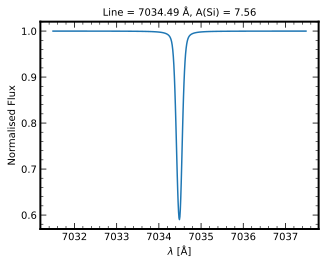

In [19]:
NLTE3Dlines[4].plot()

In [13]:
get_line_eqw(linesobj=NLTE3Dlines, 
line=4, qmax=40, define_mask=iag_int_lims[4])

[7034.55054801 7034.56148654 7034.57263512 7034.58402656 7034.59569481
 7034.60767512 7034.62000424 7034.63272053 7034.64586421 7034.65947749
 7034.67360483 7034.68829309 7034.70359179 7034.71955333 7034.73623324
 7034.75369045 7034.77198756 7034.79119112 7034.81137197 7034.83260558
 7034.85497238 7034.87855814 7034.90345441 7034.92975892 7034.95757604
 7034.98701732 7035.01820194 7035.05125733 7035.08631979 7035.12353505
 7035.16305905]
[7034.55054801 7034.56148654 7034.57263512 7034.58402656 7034.59569481
 7034.60767512 7034.62000424 7034.63272053 7034.64586421 7034.65947749
 7034.67360483 7034.68829309 7034.70359179 7034.71955333 7034.73623324
 7034.75369045 7034.77198756 7034.79119112 7034.81137197 7034.83260558
 7034.85497238 7034.87855814 7034.90345441 7034.92975892 7034.95757604
 7034.98701732 7035.01820194 7035.05125733 7035.08631979 7035.12353505
 7035.16305905]
[7034.55054801 7034.56148654 7034.57263512 7034.58402656 7034.59569481
 7034.60767512 7034.62000424 7034.63272053 70

[13.523604494461969,
 15.111645171083861,
 15.000107047962622,
 14.637340220489982,
 13.602400658226891,
 11.62580572449437]

In [15]:
get_line_eqw(linesobj=NLTE3Dlines, 
line=4, qmax=40, define_mask=iag_int_lims[4])

[0.75200699 0.80050961 0.84280489 0.87760996 0.90506344 0.92618486
 0.94228212 0.95458873 0.96409924 0.97148573 0.97723055 0.98165203
 0.98501667 0.98757485 0.98954327 0.99109747 0.99235606 0.99339663
 0.99426923 0.99500856 0.99564004 0.99618321 0.99665289 0.99706071
 0.99741621 0.99772708 0.99799958 0.99823924 0.99845009 0.99863619
 0.99880037]
[0.72144003 0.76486274 0.80619235 0.84367993 0.87644755 0.90420075
 0.92697302 0.94497845 0.95867445 0.96873091 0.97596061 0.9811505
 0.98490344 0.98765109 0.98970922 0.99129669 0.99255892 0.99359058
 0.99445034 0.9951758  0.99579353 0.99632322 0.99677999 0.99717589
 0.9975202  0.99782092 0.99808398 0.99831487 0.99851774 0.99869661
 0.9988542 ]
[0.72992793 0.77561216 0.81762758 0.85442773 0.88549959 0.91108539
 0.93172737 0.94796113 0.96039909 0.96970964 0.97654329 0.98153807
 0.98520072 0.98790709 0.98993031 0.99147993 0.99270795 0.99371079
 0.99454729 0.9952543  0.99585733 0.99637524 0.9968225  0.99721079
 0.997549   0.99784459 0.99810357 0.9

[13.523604494461969,
 15.111645171083861,
 15.000107047962622,
 14.637340220489982,
 13.602400658226891,
 11.62580572449437]

In [ ]:
def ax_text(i,j, ax, posx, posy, color='k'):
    
    d = {'3D non-LTE Abund. diff.:': np.round(corrections[i,j],4)
        }
    
    add_text_to_ax(posx, posy, nice_string_output(d), ax, fontsize=10, color=color)
    return None

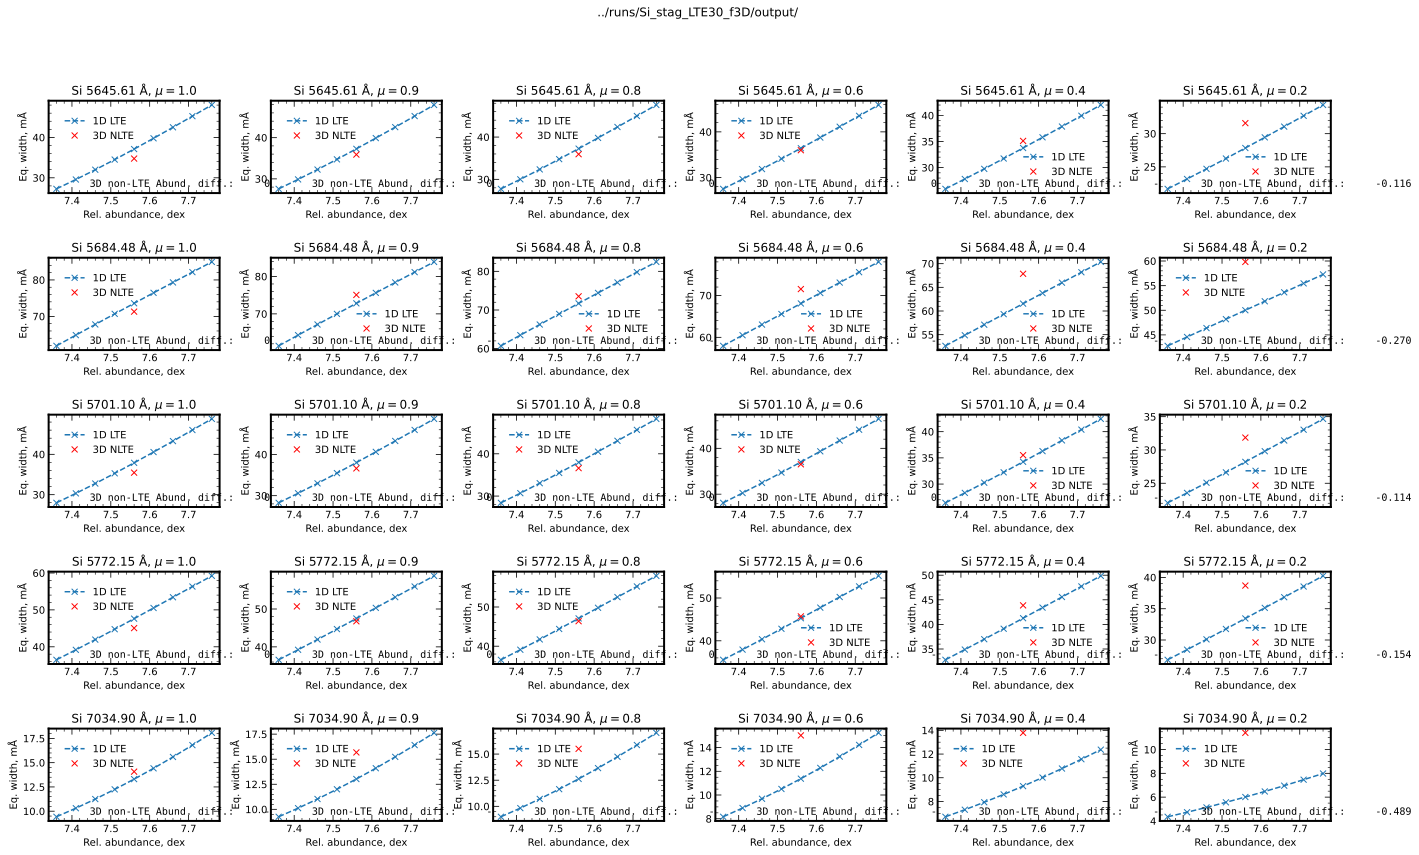

In [ ]:
fig_ew, ax_ew = plt.subplots(len(major_krs), len(sol_mus), figsize=(22,13))

abundances = LTE1d_cog.abnds

for i, kr in enumerate(major_krs):
    for j, mu in enumerate(sol_mus):
        ax_ew[i,j].plot(LTE1d_cog.abnds, eqwidths_1dlte[i,j], '--x', label='1D LTE')
        ax_ew[i,j].plot(NLTE3Drunobj.abnd, eqw_NLTE[i][j], 'rx', label='3D NLTE')
        ax_ew[i,j].set_title(f'Si {m3d_centre_wavelengths[i]:.2f} Å, $\mu = {sol_mus[j]:.1f}$')
        ax_ew[i,j].set_ylabel('Eq. width, mÅ', fontsize=10)
        ax_ew[i,j].set_xlabel('Rel. abundance, dex', fontsize=10)
        ax_text(i,j, ax_ew[i,j],  0.24, 0.15)
        
        # ax_ew[i,j].grid(which='both')

        ax_ew[i,j].legend(fontsize=10)
fig_ew.suptitle(f'{NLTE3Drunfile}')
# plt.tight_layout()
plt.subplots_adjust(left=0.09, bottom=None, right=None, top=None, wspace=0.3, hspace=0.7)

# fig_ew.savefig('../plots/3dabundcorr_IOSMET_5wls.pdf')

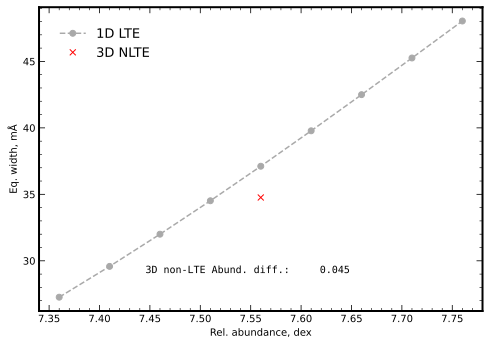

In [ ]:
fig_ew, ax_ew = plt.subplots(1, figsize=(7,5))
i=j=0    
plt.rcParams.update({'font.size': 13})


abundances = LTE1d_cog.abnds
ax_ew.plot(LTE1d_cog.abnds, eqwidths_1dlte[i,j], '--o', label='1D LTE', color='darkgray')
ax_ew.plot(NLTE3Drunobj.abnd, eqw_NLTE[i][j], 'rx', label='3D NLTE')
# ax_ew.set_title(f'Si {m3d_centre_wavelengths[i]:.2f} Å, $\mu = {sol_mus[j]:.1f}$')
ax_ew.set_ylabel('Eq. width, mÅ')
ax_ew.set_xlabel('Rel. abundance, dex')
ax_text(0,0, ax_ew,  0.24, 0.15)

# ax_ew[i,j].grid(which='both')

ax_ew.legend()
# fig_ew.suptitle(f'{NLTE3Drunfile}')
plt.tight_layout()
# fig_ew.savefig('../plots/abund_diff_example.pdf')

In [ ]:
# np.save('../mdata/3DNLTE_eqs_30f3D_noiosmet_5wl', eqw_NLTE)
# np.save('../mdata/3DNLTE_abund_corr_no_iosmet_5wls.npy', corrections)
# np.save('../mdata/1DNLTE_abund_corr_no_iosmet_5wls', corrections)
# np.save('../mdata/3DLTE_abund_corr_2404', corrections)